# Objective

Determine the functional differences (if any exist to be found) in the proteome of the microbiome between RAG-Tcell Transfer (IBD Model) and RAG (Helthy Control) mice.  Ratio quantification using N15 isotopic labeling of the proteins of the microbiome should help to elucidate minor differences, while spectoral counting methods will be used to identify gross differences in proteomic content.

## Read and store sample data as classes

In [1]:
import sys
sys.path.append('..')
import os
from itertools import chain
import shelve
from tqdm import tqdm
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

from scripts import utils
from scripts.analysis import build_loci
from scripts.analysis.DBInfo import DBInfo

BASE = '../data'

db_info = DBInfo("compil_mgm")
metadata = build_loci.read_metadata(os.path.join(BASE,"metadata.csv"))

`metadata.csv` was generated using the script `make_metadata.py` located in the `scripts` directory.  This file extracts metadata about each sample encoded into the directory names, and places them into a csv file that is used by build loci to perform the correct analysis pipelines on a given sample.

In [2]:
samples = shelve.open(os.path.join(BASE,"Samples.shelve"))
"""
for sample_name, sample_info in tqdm(list(metadata.iteritems())):
    sample = build_loci.Sample(sample_name, sample_info.path, db_info, sample_info)
    samples[sample.sample_name] = sample
"""

'\nfor sample_name, sample_info in tqdm(list(metadata.iteritems())):\n    sample = build_loci.Sample(sample_name, sample_info.path, db_info, sample_info)\n    samples[sample.sample_name] = sample\n'

In [3]:
protein_clusters = shelve.open(os.path.join(BASE,"Protein_clusters.shelve"))
"""
for name, sample in tqdm(samples.items()):
    protein_clusters[name] = sample.build_protein_clusters()
"""

'\nfor name, sample in tqdm(samples.items()):\n    protein_clusters[name] = sample.build_protein_clusters()\n'

Get the list of N15 quantified, unenriched samples.

In [4]:
unenr_keys = []
for key, sample in samples.items():
    if sample['quant'] and not sample['enriched']:
        unenr_keys.append(key)
unenr_keys = sorted(unenr_keys, key=lambda x: (x.split('_')[2], x.split('_')[-1], x.split('_')[-2]=='N'))

In [5]:
rt_un_keys = [key for key in unenr_keys if not '_N_' in key]
rag_un_keys = [key for key in unenr_keys if '_N_' in key]

## Plot venn diagrams showing run to run cluster composition for the samples

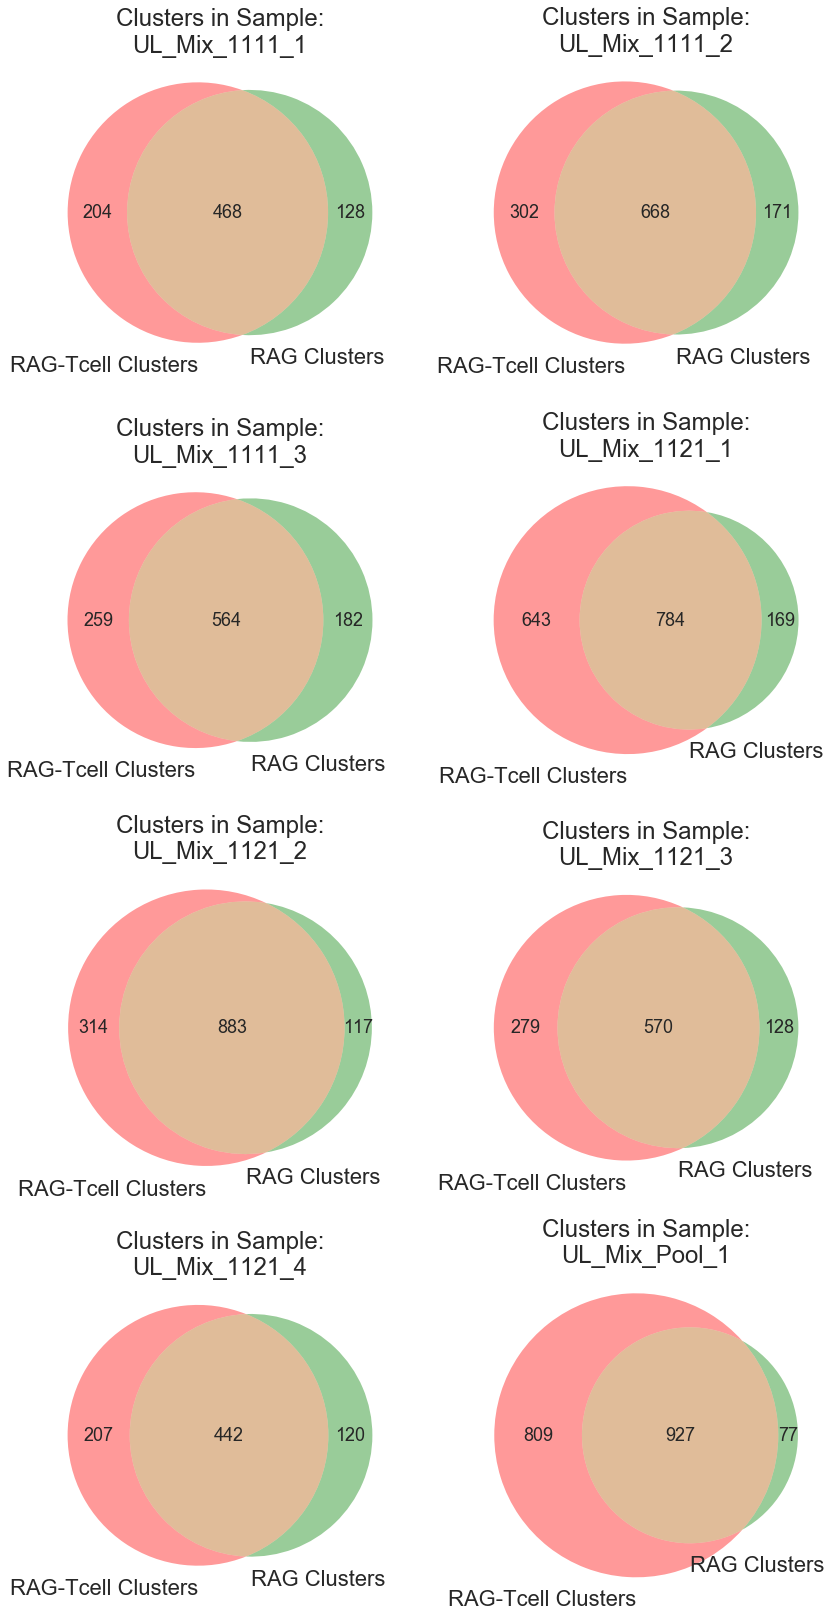

In [6]:
from matplotlib_venn import venn2

rows = len(unenr_keys)//4

fig, ax = plt.subplots(rows,2)
fig.set_tight_layout(False)
fig.set_size_inches(14,28)

for i, (l, h) in enumerate(zip(rt_un_keys, rag_un_keys)):
    light = set(p.cluster_id for p in protein_clusters[l])
    heavy = set(p.cluster_id for p in protein_clusters[h])
    
    v = venn2((light, heavy), ('RAG-Tcell Clusters', 'RAG Clusters'), ax = ax[i//2][i%2])
    
    for txt in v.set_labels:
        txt.set_fontsize(22)
    for text in v.subset_labels:
        text.set_fontsize(18)
    ax[i//2][i%2].set_title('Clusters in Sample:\n{}'.format(l), size = 24)

plt.savefig(os.path.join(BASE, 'unenr_clusters.png'), dpi = 100);

`UL_Mix_1121_1` (Row 2, Right side) and `UL_Mix_Pool_1` (Bottom Row, Right side) both look like they have diminished RAG Clusters, definitely looking different from the rest.  

## Make Datatables from the data

In [7]:
"""
unenr_clusters = {k:v for k, v in protein_clusters.items() if k in unenr_keys}
sample_pep_quant = {samples[k].sample_name:samples[k].pep_quant for k in unenr_keys}
sample_quant_dict = {samples[k].sample_name:samples[k]['n15'] for k in unenr_keys}

unenr_grouped_loci = build_loci.group_across_samples(list(chain(*unenr_clusters.values())), sample_pep_quant, sample_quant_dict, db_info)
for locus in tqdm(unenr_grouped_loci):
    locus.annotate()
    locus.quantify(rt_un_keys) #Only quantify ratios across N14 identifications
utils.save(unenr_grouped_loci, os.path.join(BASE,"unenriched_grouped_loci.pkl.gz"), force=True)
"""
unenr_grouped_loci = utils.load(os.path.join(BASE,"unenriched_grouped_loci.pkl.gz"))

load obo file ../scripts/go-basic.obo
46933 nodes imported
  0%|          | 0/3277 [00:00<?, ?it/s]/Users/mmayers/projects/n15_mice/venv/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/mmayers/projects/n15_mice/venv/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
100%|██████████| 3277/3277 [01:00<00:00, 54.49it/s]


In [8]:
unenr_samples = {k:v for k, v in samples.items() if k in unenr_keys}
nf = build_loci.yates_normalization(unenr_samples)

316 common peptides for Normalizaion


In [9]:
for locus in unenr_grouped_loci:
    locus.normalize(nf)
build_loci.to_json(unenr_grouped_loci, unenr_keys, os.path.join(BASE, 'unenriched_Rag_Tcell_ratio.json'))

### Datatable Link
**[Unenriched Protein Clusters](http://wl-cmadmin:8000/ratiotable/unenriched_Rag_Tcell_ratio)**

## PCA Plot of the Unenriched Samples

explained variance ratios: [ 0.17125827  0.14612717]


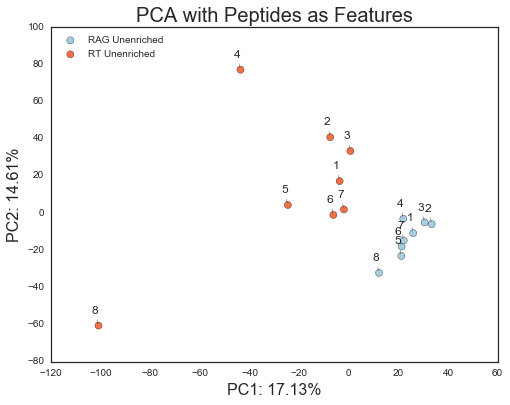

In [11]:
df = build_loci.to_df(unenr_grouped_loci, ratios=True, peptides=True)
build_loci.plot_pca(df, metadata[unenr_keys], title='PCA with Peptides as Features', group_name='category', loc=2, label_points=True)

explained variance ratios: [ 0.22488552  0.14031103]


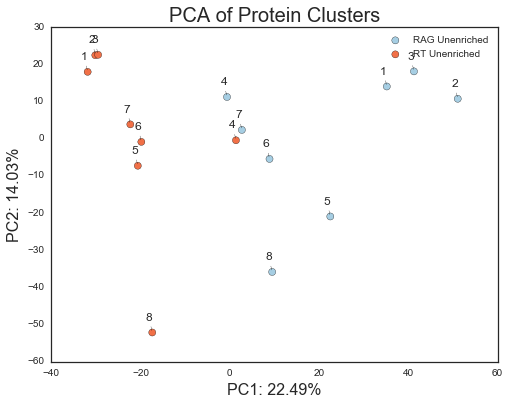

In [12]:
df = build_loci.to_df(unenr_grouped_loci, ratios=True, peptides=False)
build_loci.plot_pca(df, metadata[unenr_keys], group_name='category', loc=1, label_points=True)

Sample 8 definitely looks like an outlier, Sample 4 potentially, when examining by peptides.  Will try filtering them out and looking again.

In [13]:
def remove_prob_sample(prob_samp_numb, all_keys, l_keys, h_keys):

    problem_samples = []
    problem_samples.append(l_keys[prob_samp_numb-1])
    problem_samples.append(h_keys[prob_samp_numb-1])

    for sample in problem_samples:
        all_keys.remove(sample)
        if sample in l_keys:
            l_keys.remove(sample)
        if sample in h_keys:
            h_keys.remove(sample)
    
    return all_keys, l_keys, h_keys

In [14]:
enr_keys, rt_enr_keys, rag_enr_keys = remove_prob_sample(8, unenr_keys, rt_un_keys, rag_un_keys)

In [15]:
"""
unenr_clusters = {k:v for k, v in protein_clusters.items() if k in unenr_keys}
sample_pep_quant = {samples[k].sample_name:samples[k].pep_quant for k in unenr_keys}
sample_quant_dict = {samples[k].sample_name:samples[k]['n15'] for k in unenr_keys}

unenr_grouped_loci = build_loci.group_across_samples(list(chain(*unenr_clusters.values())), sample_pep_quant, sample_quant_dict, db_info)
for locus in tqdm(unenr_grouped_loci):
    locus.annotate()
    locus.quantify(rt_un_keys) #Only quantify ratios across N14 identifications
utils.save(unenr_grouped_loci, os.path.join(BASE,"unenriched_grouped_loci_filt.pkl.gz"), force=True)
"""
unenr_grouped_loci = utils.load(os.path.join(BASE,"unenriched_grouped_loci_filt.pkl.gz"))

  0%|          | 0/2775 [00:00<?, ?it/s]/Users/mmayers/projects/n15_mice/venv/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/mmayers/projects/n15_mice/venv/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
100%|██████████| 2775/2775 [00:48<00:00, 57.53it/s]


explained variance ratios: [ 0.19176062  0.14550448]


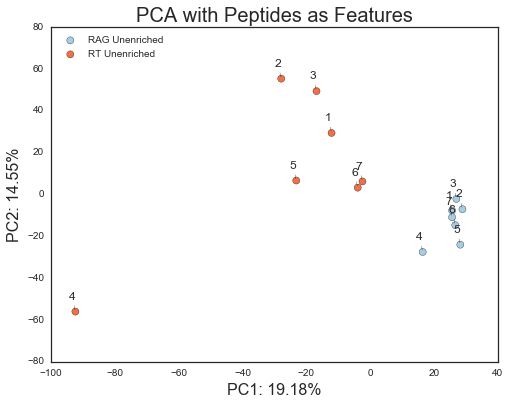

In [16]:
df = build_loci.to_df(unenr_grouped_loci, ratios=True, peptides=True)
build_loci.plot_pca(df, metadata[unenr_keys], title='PCA with Peptides as Features', group_name='category', loc=2, label_points=True)

explained variance ratios: [ 0.26392304  0.13751751]


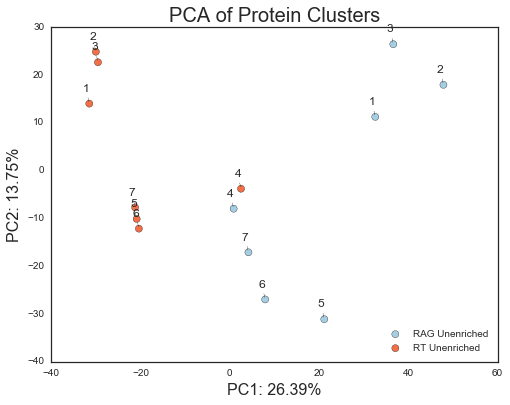

In [18]:
df = build_loci.to_df(unenr_grouped_loci, ratios=True, peptides=False)
build_loci.plot_pca(df, metadata[unenr_keys], group_name='category', loc=4, label_points=True)

In [22]:
enr_keys, rt_enr_keys, rag_enr_keys = remove_prob_sample(4, unenr_keys, rt_un_keys, rag_un_keys)

In [24]:
"""
unenr_clusters = {k:v for k, v in protein_clusters.items() if k in unenr_keys}
sample_pep_quant = {samples[k].sample_name:samples[k].pep_quant for k in unenr_keys}
sample_quant_dict = {samples[k].sample_name:samples[k]['n15'] for k in unenr_keys}

unenr_grouped_loci = build_loci.group_across_samples(list(chain(*unenr_clusters.values())), sample_pep_quant, sample_quant_dict, db_info)
for locus in tqdm(unenr_grouped_loci):
    locus.annotate()
    locus.quantify(rt_un_keys) #Only quantify ratios across N14 identifications
utils.save(unenr_grouped_loci, os.path.join(BASE,"unenriched_grouped_loci_filt1.pkl.gz"), force=True)
"""
unenr_grouped_loci = utils.load(os.path.join(BASE,"unenriched_grouped_loci_filt1.pkl.gz"))

  0%|          | 0/2420 [00:00<?, ?it/s]/Users/mmayers/projects/n15_mice/venv/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/mmayers/projects/n15_mice/venv/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
100%|██████████| 2420/2420 [00:42<00:00, 57.44it/s]


explained variance ratios: [ 0.2038006   0.16821151]


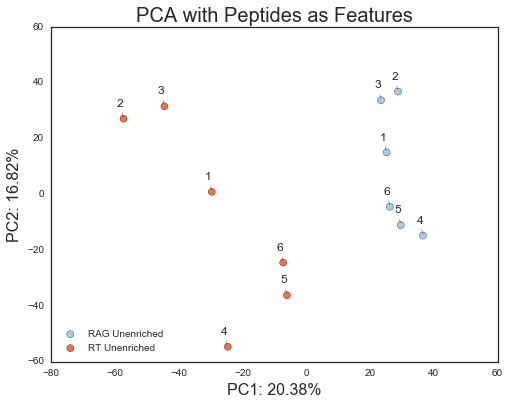

In [25]:
df = build_loci.to_df(unenr_grouped_loci, ratios=True, peptides=True)
build_loci.plot_pca(df, metadata[unenr_keys], title='PCA with Peptides as Features', group_name='category', loc=3, label_points=True)

explained variance ratios: [ 0.31447825  0.16577402]


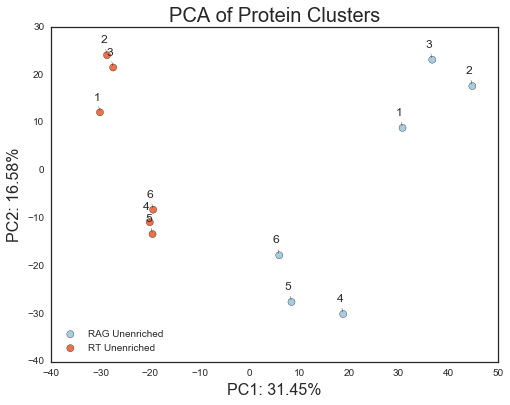

In [26]:
df = build_loci.to_df(unenr_grouped_loci, ratios=True, peptides=False)
build_loci.plot_pca(df, metadata[unenr_keys], group_name='category', loc=3, label_points=True)

# Enriched Samples

In [27]:
enr_keys = []
ctl_keys = []
for key, sample in samples.items():
    if sample['quant'] and sample['enriched'] and sample['probe'] == 'CMK':
        enr_keys.append(key)
    if sample['quant'] and sample['enriched'] and sample['probe'] == 'DMSO':
        ctl_keys.append(key)
enr_keys = sorted(enr_keys, key=lambda x: (x.split('_')[2], x.split('_')[-1], x.split('_')[-2]=='N'))
ctl_keys = sorted(ctl_keys, key=lambda x: (x.split('_')[2], x.split('_')[-1], x.split('_')[-2]=='N'))

In [28]:
rt_enr_keys = [key for key in enr_keys if not '_N_' in key]
rag_enr_keys = [key for key in enr_keys if '_N_' in key]

## Filter out clusters commonly found in DMSO Controls

If 10+ counts in a sample, most likely, this locus has a non-specific interaction to the beads, and isn't just noise

In [29]:
loci_to_filter = []
all_loci = []
for sample in ctl_keys:
    for locus in protein_clusters[sample]:
        if locus.quantification['counts'] > 10:
            loci_to_filter.append(locus.cluster_id)
        all_loci.append(locus.cluster_id)
loci_to_filter = set(loci_to_filter)
all_loci = set(all_loci)

In [30]:
len(loci_to_filter)

242

In [31]:
len(all_loci)

415

In [32]:
filt_clusters = dict()
for sample in enr_keys:
    count = 0
    a = protein_clusters[sample]
    print(sample, len(a), ':', end='')
    for locus in protein_clusters[sample]:
        if locus.cluster_id in loci_to_filter:
            a.remove(locus)
            count += 1
    print(len(a), ':', count)
    filt_clusters[sample] = a

CL_Mix_1120_1 1581 :1484 : 97
CL_Mix_1120_N_1 667 :636 : 31
CL_Mix_Pool_1 1550 :1398 : 152
CL_Mix_Pool_N_1 868 :829 : 39
CL_Mix_Pool_2 740 :637 : 103
CL_Mix_Pool_N_2 530 :500 : 30
CL_Mix_Pool_3 1147 :1023 : 124
CL_Mix_Pool_N_3 640 :604 : 36
CL_Mix_Pool_4 800 :681 : 119
CL_Mix_Pool_N_4 357 :326 : 31
CL_Mix_Pool_5 1568 :1434 : 134
CL_Mix_Pool_N_5 581 :545 : 36


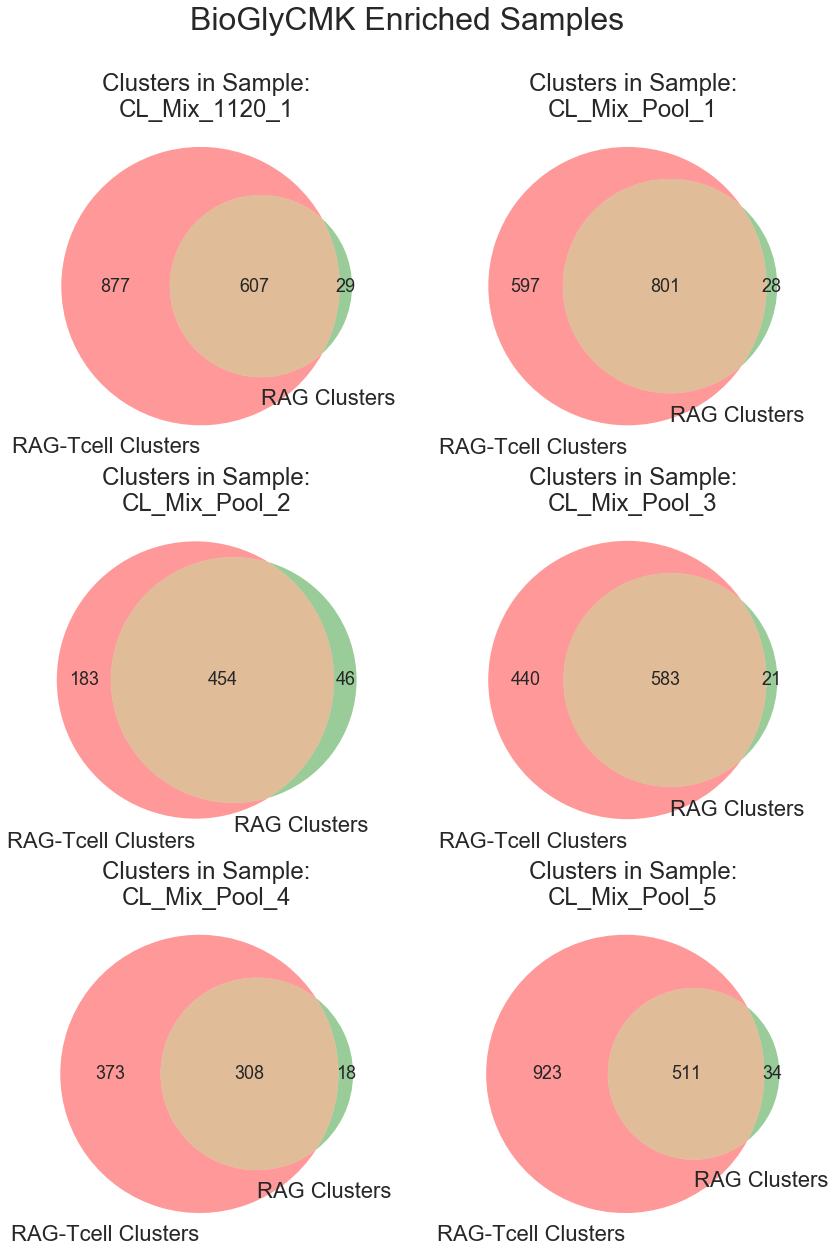

In [33]:
rows = len(enr_keys)//4

fig, ax = plt.subplots(rows,2)
fig.set_tight_layout(False)
fig.set_size_inches(14,20)
fig.suptitle('BioGlyCMK Enriched Samples', size=32)


for i, (l, h) in enumerate(zip(rt_enr_keys, rag_enr_keys)):
    light = set(p.cluster_id for p in filt_clusters[l])
    heavy = set(p.cluster_id for p in filt_clusters[h])
    
    v = venn2((light, heavy), ('RAG-Tcell Clusters', 'RAG Clusters'), ax = ax[i//2][i%2])
    
    for txt in v.set_labels:
        txt.set_fontsize(22)
    for text in v.subset_labels:
        text.set_fontsize(18)
    ax[i//2][i%2].set_title('Clusters in Sample:\n{}'.format(l), size = 24)

plt.savefig(os.path.join(BASE, 'enr_clusters.png'), dpi = 100);

In [34]:
"""
sample_pep_quant = {samples[k].sample_name:samples[k].pep_quant for k in enr_keys}
sample_quant_dict = {samples[k].sample_name:samples[k]['n15'] for k in enr_keys}

enr_grouped_loci = build_loci.group_across_samples(list(chain(*filt_clusters.values())), sample_pep_quant, sample_quant_dict, db_info)
for locus in tqdm(enr_grouped_loci):
    locus.annotate()
    locus.quantify(rt_enr_keys) #Only quantify ratios across N14 identifications
utils.save(enr_grouped_loci, os.path.join(BASE,"enriched_grouped_loci.pkl.gz"), force=True)
"""
enr_grouped_loci = utils.load(os.path.join(BASE,"enriched_grouped_loci.pkl.gz"))

  0%|          | 0/2817 [00:00<?, ?it/s]/Users/mmayers/projects/n15_mice/venv/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/mmayers/projects/n15_mice/venv/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
100%|██████████| 2817/2817 [00:54<00:00, 51.54it/s]


In [35]:
enriched_samples = {k:v for k, v in samples.items() if k in enr_keys}
nf = build_loci.yates_normalization(enriched_samples)

292 common peptides for Normalizaion


In [36]:
for locus in enr_grouped_loci:
    locus.normalize(nf)
build_loci.to_json(enr_grouped_loci, enr_keys, '../data/bioGlyCMK_enriched_Rag_Tcell_ratio.json')

### Datatable of all loci and all samples
**[Link to Datatable](http://wl-cmadmin:8000/ratiotable/bioGlyCMK_enriched_Rag_Tcell_ratio)**

explained variance ratios: [ 0.22543078  0.19783792]


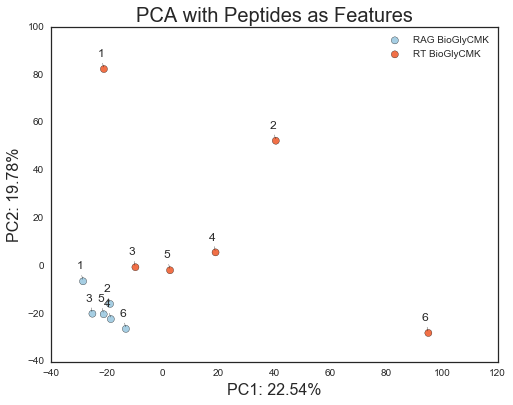

In [37]:
df = build_loci.to_df(enr_grouped_loci, ratios=True, peptides=True)
build_loci.plot_pca(df, metadata[enr_keys], title='PCA with Peptides as Features', group_name='category', loc=1, label_points=True)

explained variance ratios: [ 0.26254021  0.17000922]


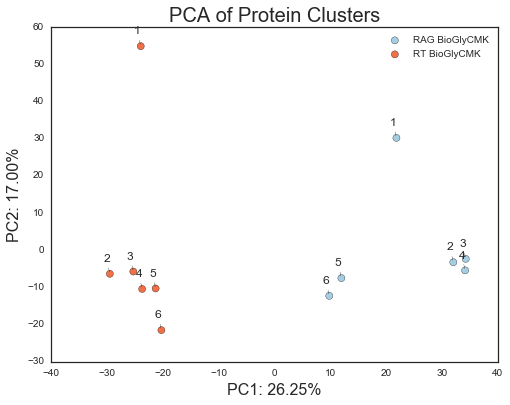

In [39]:
df = build_loci.to_df(enr_grouped_loci, ratios=True, peptides=False)
build_loci.plot_pca(df, metadata[enr_keys], group_name='category', loc=1, label_points=True)

In [40]:
enr_keys, rt_enr_keys, rag_enr_keys = remove_prob_sample(1, enr_keys, rt_enr_keys, rag_enr_keys)
"""
filt_clusters = {k:v for k, v in filt_clusters.items() if k in enr_keys}
sample_pep_quant = {samples[k].sample_name:samples[k].pep_quant for k in enr_keys}
sample_quant_dict = {samples[k].sample_name:samples[k]['n15'] for k in enr_keys}
enr_grouped_loci = build_loci.group_across_samples(list(chain(*filt_clusters.values())), sample_pep_quant, sample_quant_dict, db_info)
for locus in tqdm(enr_grouped_loci):
    locus.annotate()
    locus.quantify(rt_enr_keys) #Only quantify ratios across N14 identifications
utils.save(enr_grouped_loci, os.path.join(BASE,"enriched_grouped_loci_filt1.pkl.gz"), force=True)
"""
enr_grouped_loci = utils.load(os.path.join(BASE,"enriched_grouped_loci_filt1.pkl.gz"))

  0%|          | 0/2261 [00:00<?, ?it/s]/Users/mmayers/projects/n15_mice/venv/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/mmayers/projects/n15_mice/venv/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
100%|██████████| 2261/2261 [00:40<00:00, 55.26it/s]


explained variance ratios: [ 0.2813288   0.23646629]


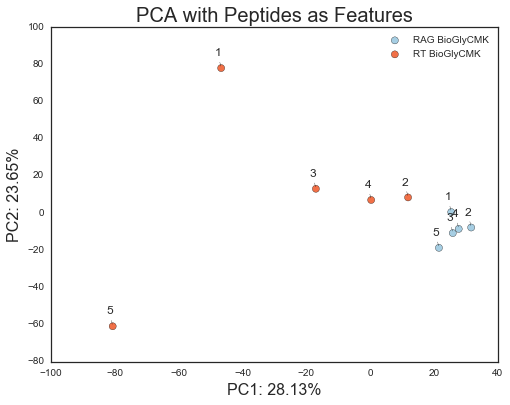

In [41]:
df = build_loci.to_df(enr_grouped_loci, ratios=True, peptides=True)
build_loci.plot_pca(df, metadata[enr_keys], title='PCA with Peptides as Features', group_name='category', loc=1, label_points=True)

explained variance ratios: [ 0.31621025  0.14936092]


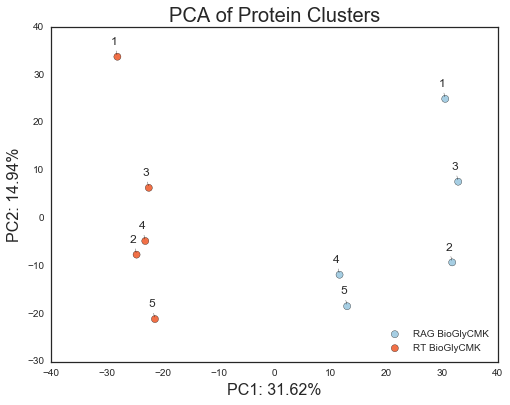

In [43]:
df = build_loci.to_df(enr_grouped_loci, ratios=True, peptides=False)
build_loci.plot_pca(df, metadata[enr_keys], group_name='category', loc=4, label_points=True)

In [44]:
enr_keys, rt_enr_keys, rag_enr_keys = remove_prob_sample(5, enr_keys, rt_enr_keys, rag_enr_keys)
"""
filt_clusters = {k:v for k, v in filt_clusters.items() if k in enr_keys}
sample_pep_quant = {samples[k].sample_name:samples[k].pep_quant for k in enr_keys}
sample_quant_dict = {samples[k].sample_name:samples[k]['n15'] for k in enr_keys}
enr_grouped_loci = build_loci.group_across_samples(list(chain(*filt_clusters.values())), sample_pep_quant, sample_quant_dict, db_info)
for locus in tqdm(enr_grouped_loci):
    locus.annotate()
    locus.quantify(rt_enr_keys) #Only quantify ratios across N14 identifications
utils.save(enr_grouped_loci, os.path.join(BASE,"enriched_grouped_loci_filt2.pkl.gz"), force=True)
"""
enr_grouped_loci = utils.load(os.path.join(BASE,"enriched_grouped_loci_filt2.pkl.gz"))

  0%|          | 0/1791 [00:00<?, ?it/s]/Users/mmayers/projects/n15_mice/venv/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/mmayers/projects/n15_mice/venv/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
100%|██████████| 1791/1791 [00:30<00:00, 63.91it/s]


explained variance ratios: [ 0.35215926  0.18890861]


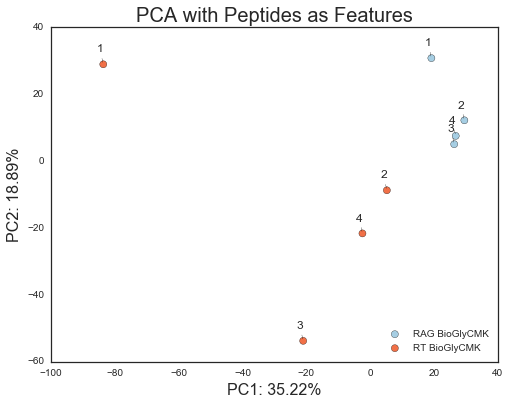

In [45]:
df = build_loci.to_df(enr_grouped_loci, ratios=True, peptides=True)
build_loci.plot_pca(df, metadata[enr_keys], title='PCA with Peptides as Features', group_name='category', loc=4, label_points=True)

explained variance ratios: [ 0.36512303  0.19168645]


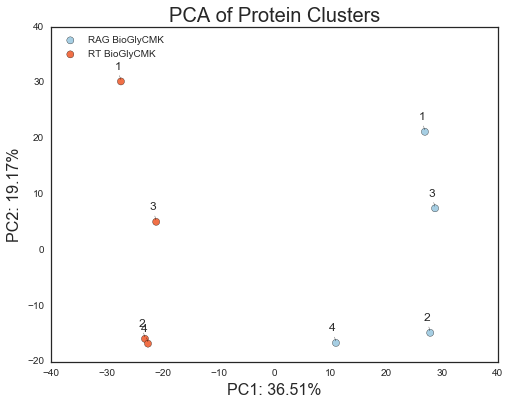

In [46]:
df = build_loci.to_df(enr_grouped_loci, ratios=True, peptides=False)
build_loci.plot_pca(df, metadata[enr_keys], group_name='category', loc=2, label_points=True)

In [47]:
both_clusters = filt_clusters
both_clusters.update(unenr_clusters)
both_keys = enr_keys + unenr_keys

In [48]:
"""
sample_pep_quant = {samples[k].sample_name:samples[k].pep_quant for k in both_keys}
sample_quant_dict = {samples[k].sample_name:samples[k]['n15'] for k in both_keys}
grouped_loci = build_loci.group_across_samples(list(chain(*both_clusters.values())), sample_pep_quant, sample_quant_dict, db_info)
for locus in tqdm(grouped_loci):
    locus.annotate()
    locus.quantify(rt_un_keys+rt_enr_keys) #Only quantify ratios across N14 identifications
utils.save(grouped_loci, os.path.join(BASE,"grouped_loci.pkl.gz"), force=True)
"""
grouped_loci = utils.load(os.path.join(BASE,"grouped_loci.pkl.gz"))

  0%|          | 0/3368 [00:00<?, ?it/s]/Users/mmayers/projects/n15_mice/venv/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/mmayers/projects/n15_mice/venv/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
100%|██████████| 3368/3368 [01:00<00:00, 56.11it/s]


explained variance ratios: [ 0.18221213  0.11239448]


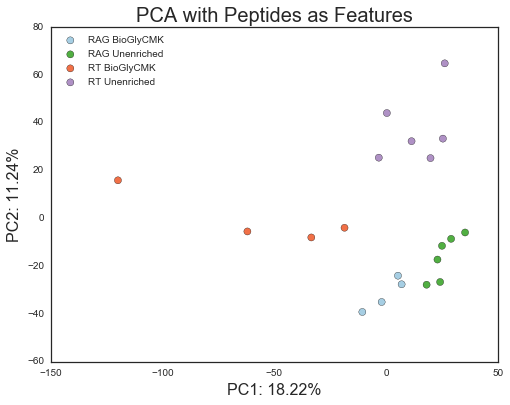

In [49]:
df = build_loci.to_df(grouped_loci, ratios=True, peptides=True)
build_loci.plot_pca(df, metadata[unenr_keys+enr_keys], title='PCA with Peptides as Features', group_name='category', loc=2, label_points=False)

explained variance ratios: [ 0.21669729  0.15918191]


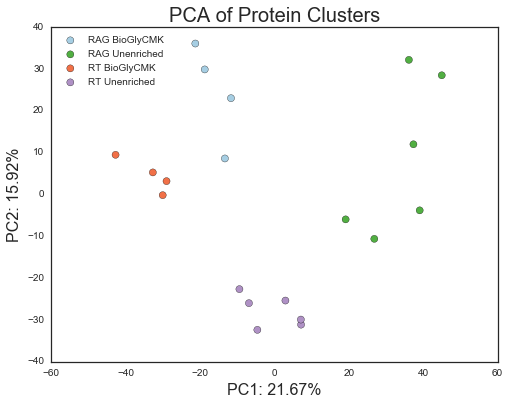

In [50]:
df = build_loci.to_df(grouped_loci, ratios=True, peptides=False)
build_loci.plot_pca(df, metadata[unenr_keys+enr_keys], group_name='category', loc=2, label_points=False)

# Volcano plot for significantly enriched loci

In [53]:
"""
rt_clusters = {k:v for k, v in protein_clusters.items() if k in rt_un_keys}
sample_pep_quant = {samples[k].sample_name:samples[k].pep_quant for k in rt_un_keys}
sample_quant_dict = {samples[k].sample_name:samples[k]['n15'] for k in rt_un_keys}
rt_un_grouped_loci = build_loci.group_across_samples(list(chain(*rt_clusters.values())), sample_pep_quant, sample_quant_dict, db_info)
for locus in tqdm(rt_un_grouped_loci):
    locus.annotate()
    locus.quantify()
utils.save(rt_un_grouped_loci, os.path.join(BASE,"ragtcell_unenriched_grouped_loci.pkl.gz"), force=True)
"""
rt_un_grouped_loci = utils.load(os.path.join(BASE,"ragtcell_unenriched_grouped_loci.pkl.gz"))

  0%|          | 0/2137 [00:00<?, ?it/s]/Users/mmayers/projects/n15_mice/venv/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/mmayers/projects/n15_mice/venv/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
100%|██████████| 2137/2137 [00:37<00:00, 60.31it/s]


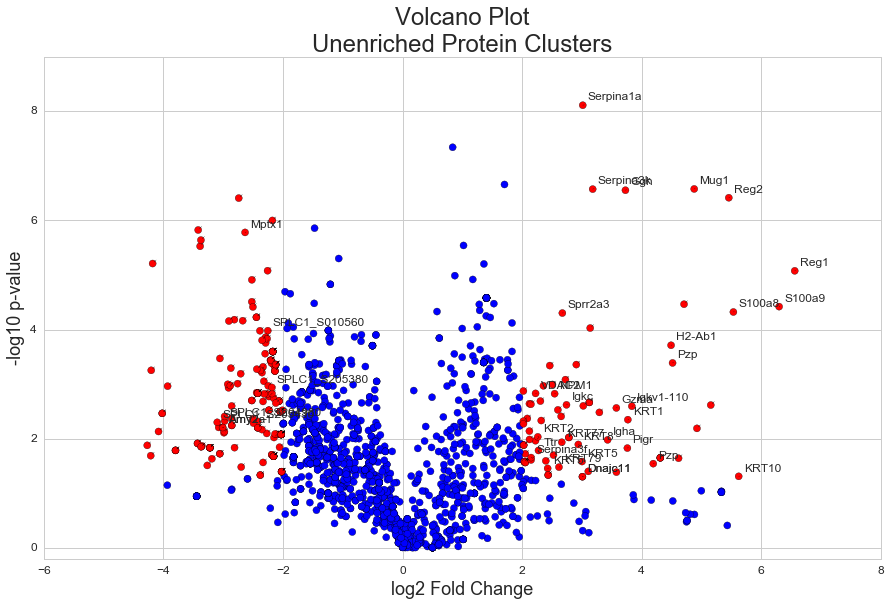

In [54]:
build_loci.plot_volcano(rt_un_grouped_loci, title='Volcano Plot\nUnenriched Protein Clusters', labels=True)

In [55]:
build_loci.sig_up_json(rt_un_grouped_loci, rt_un_keys, os.path.join(BASE, 'unenriched_sig_up.json'), norm=False)
build_loci.sig_down_json(rt_un_grouped_loci, rt_un_keys, os.path.join(BASE, 'unenriched_sig_down.json'), norm=False)

## The list of up and downregulated Protein Clusters can be found here:  
**[Significantly upregulated in Tcell Transfer](http://wl-cmadmin:8000/ratiotable/unenriched_sig_up)**  
**[Significantly downregulated in Tcell Transfer](http://wl-cmadmin:8000/ratiotable/unenriched_sig_down)**

### Enriched Samples

In [56]:
"""
rt_enr_clusters = {k:v for k, v in protein_clusters.items() if k in rt_enr_keys}
sample_pep_quant = {samples[k].sample_name:samples[k].pep_quant for k in rt_enr_keys}
sample_quant_dict = {samples[k].sample_name:samples[k]['n15'] for k in rt_enr_keys}
rt_enr_grouped_loci = build_loci.group_across_samples(list(chain(*rt_enr_clusters.values())), sample_pep_quant, sample_quant_dict, db_info)
for locus in tqdm(rt_enr_grouped_loci):
    locus.annotate()
    locus.quantify()
utils.save(rt_enr_grouped_loci, os.path.join(BASE,"ragtcell_enriched_grouped_loci.pkl.gz"), force=True)
"""
#rt_enr_grouped_loci = utils.load(os.path.join(BASE,"ragtcell_enriched_grouped_loci.pkl.gz"))

  0%|          | 0/1910 [00:00<?, ?it/s]/Users/mmayers/projects/n15_mice/venv/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
  0%|          | 7/1910 [00:00<01:21, 23.49it/s]/Users/mmayers/projects/n15_mice/venv/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
100%|██████████| 1910/1910 [00:37<00:00, 50.32it/s]


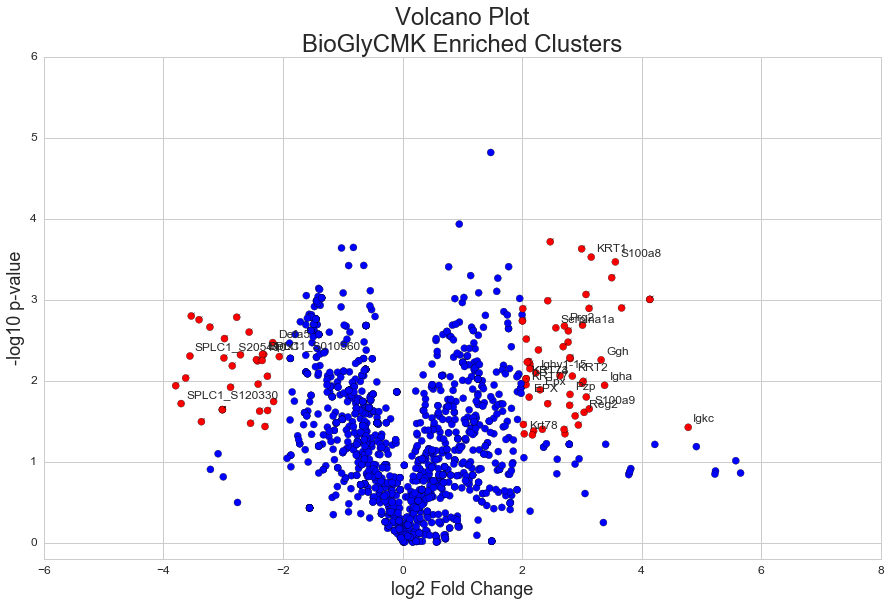

In [57]:
build_loci.plot_volcano(rt_enr_grouped_loci, title='Volcano Plot\nBioGlyCMK Enriched Clusters', labels=True)

In [58]:
build_loci.sig_up_json(rt_enr_grouped_loci, rt_enr_keys, os.path.join(BASE, 'enriched_sig_up.json'), norm=False)
build_loci.sig_down_json(rt_enr_grouped_loci, rt_enr_keys, os.path.join(BASE, 'enriched_sig_down.json'), norm=False)

## View Significance tables here:  
**[Significantly upregulated in Tcell Transfer](http://wl-cmadmin:8000/ratiotable/enriched_sig_up)**  
**[Significantly downregulated in Tcell Transfer](http://wl-cmadmin:8000/ratiotable/enriched_sig_down)**

# GESA

Simple hypergeometric tests to see if a given GO term has a significantly greater number of occurances in one sample type over another time.  Ratios and weights are not taken into account in this metodology (execpt in that those with no ratio or counts are ignored).  Instead, the number of protein loci in a given sample type with a specific GO term is the primary metric for determining enrichment.


### Unenriched: RAG vs Tcell

In [114]:
from scripts.analysis import gsea
from collections import defaultdict
g = gsea.GSEA()

# Assign groups to each locus
groups = {'RAG': rag_un_keys, 'Tcell': rt_un_keys}

for locus in unenr_grouped_loci:
    locus.group = []
    samples_in_locus = {sample for sample, quant in locus.quantification.items() if quant['ratio'] > 0}
    for group, members in groups.items():
        if set(members) & samples_in_locus:
            locus.group.append(group)
    
# Get go terms for each group {CID: [GO_Terms], ...}
Rag = {locus.cluster_id:locus.annotations['go'] for locus in unenr_grouped_loci if 'RAG' in locus.group and 'go' in locus.annotations}
Tcell = {locus.cluster_id:locus.annotations['go'] for locus in unenr_grouped_loci if 'Tcell' in locus.group and 'go' in locus.annotations}

rag_annot = defaultdict(list)
tcell_annot = defaultdict(list)

rag_annot.update(g.generate_go_sets(Rag))
#for cluster_id, annotations in Rag.items():
#    for annotation in annotations:
#        rag_annot[annotation].append(cluster_id)
tcell_annot.update(g.generate_go_sets(Tcell))
#for cluster_id, annotations in Tcell.items():
#    for annotation in annotations:
#        tcell_annot[annotation].append(cluster_id)

annotations = {locus.cluster_id:locus.annotations['go'] for locus in unenr_grouped_loci if 'go' in locus.annotations}
#all_annotations = set(chain(*[locus.annotations['go'] for locus in grouped_loci if 'go' in locus.annotations]))

annotations = g.generate_go_sets(annotations)

all_annotations = set(list(rag_annot.keys()) + list(tcell_annot.keys()))



load obo file ../scripts/go-basic.obo
46933 nodes imported


In [115]:
# pop is group1 + group2
def enrichment(num_in_sub, num_in_pop, len_sub, len_pop, verbose = True):
    import scipy.stats as stats

    pval = stats.hypergeom.sf(num_in_sub - 1, len_pop, num_in_pop, len_sub)
    if verbose:
        print('number with condition in population: ' + str(num_in_pop))
        print('length pop: ' + str(len_pop))
        print('number with condition in subset: ' + str(num_in_sub))
        print('length sub: ' + str(len_sub))
        print('p-value >= ' + str(num_in_sub) + ': ' + str(pval))
    return pval

### RAG vs TCell

In [116]:
pv = dict()
for annotation in all_annotations:
    # number with condition in population
    num_in_pop = len(set(rag_annot[annotation])|set(tcell_annot[annotation]))
    # number with condition in subset
    num_in_sub = len(rag_annot[annotation])
    # number of proteins/clusters in pop
    len_pop = len(set(Rag.keys())|set(Tcell.keys()))
    # number of proteins/clusters in subset
    len_sub = len(Rag)
    pv[annotation] = [enrichment(num_in_sub, num_in_pop, len_sub, len_pop, verbose=False), num_in_sub, num_in_pop]

#[g.go_ontology[go].name for go in {k for k,v in pv.items() if v<0.0002}]
#pd.Series({g.go_ontology[k].name:v for k,v in pv.items() if v<0.0002}).to_frame().rename(columns={0:'p-value'}).sort_values(by=['p-value'])
res = (pd.DataFrame({g.go_ontology[k].name:v for k,v in pv.items() if v[0]<0.005})
         .T
         .rename(columns={0:'p-value', 1:'# in group', 2:'# in pop'})
         .sort_values(by=['p-value']))
res

,p-value,# in group,# in pop
small molecule binding,0.000001,551.0,555.0
carbohydrate derivative binding,0.000010,456.0,459.0
nucleoside binding,0.000014,447.0,450.0
ribonucleoside binding,0.000014,447.0,450.0
nucleoside phosphate binding,0.000048,415.0,418.0
nucleotide binding,0.000048,415.0,418.0
purine nucleotide binding,0.000048,368.0,370.0
ribonucleotide binding,0.000048,368.0,370.0
purine nucleoside binding,0.000061,362.0,364.0
purine ribonucleoside triphosphate binding,0.000061,362.0,364.0


### Tcell vs RAG

In [117]:
pv = dict()
for annotation in all_annotations:
    # number with condition in population
    num_in_pop = len(set(tcell_annot[annotation])|set(rag_annot[annotation]))
    # number with condition in subset
    num_in_sub = len(tcell_annot[annotation])
    # number of proteins/clusters in pop
    len_pop = len(set(Tcell.keys())|set(Rag.keys()))
    # number of proteins/clusters in subset
    len_sub = len(Tcell)
    pv[annotation] = [enrichment(num_in_sub, num_in_pop, len_sub, len_pop, verbose=False), num_in_sub, num_in_pop]

res = (pd.DataFrame({g.go_ontology[k].name:v for k,v in pv.items() if v[0]<0.05})
         .T
         .rename(columns={0:'p-value', 1:'# in group', 2:'# in pop'})
         .sort_values(by=['p-value']))
res

,p-value,# in group,# in pop
cellular metabolic process,0.016966,910.0,910.0


## Enriched

In [118]:
# Assign groups to each locus
groups = {'RAG': rag_enr_keys, 'Tcell': rt_enr_keys}

for locus in enr_grouped_loci:
    locus.group = []
    samples_in_locus = {sample for sample, quant in locus.quantification.items() if quant['ratio'] > 0}
    for group, members in groups.items():
        if set(members) & samples_in_locus:
            locus.group.append(group)
    
# Get go terms for each group {CID: [GO_Terms], ...}
Rag = {locus.cluster_id:locus.annotations['go'] for locus in enr_grouped_loci if 'RAG' in locus.group and 'go' in locus.annotations}
Tcell = {locus.cluster_id:locus.annotations['go'] for locus in enr_grouped_loci if 'Tcell' in locus.group and 'go' in locus.annotations}

rag_annot = defaultdict(list)
tcell_annot = defaultdict(list)

rag_annot.update(g.generate_go_sets(Rag))
#for cluster_id, annotations in Rag.items():
#    for annotation in annotations:
#        rag_annot[annotation].append(cluster_id)
tcell_annot.update(g.generate_go_sets(Tcell))
#for cluster_id, annotations in Tcell.items():
#    for annotation in annotations:
#        tcell_annot[annotation].append(cluster_id)
        
annotations = {locus.cluster_id:locus.annotations['go'] for locus in enr_grouped_loci if 'go' in locus.annotations}
#all_annotations = set(chain(*[locus.annotations['go'] for locus in grouped_loci if 'go' in locus.annotations]))
annotations = g.generate_go_sets(annotations)

all_annotations = set(list(rag_annot.keys()) + list(tcell_annot.keys()))



 ### RAG vs TCell

In [119]:
pv = dict()
for annotation in all_annotations:
    # number with condition in population
    num_in_pop = len(set(rag_annot[annotation])|set(tcell_annot[annotation]))
    # number with condition in subset
    num_in_sub = len(rag_annot[annotation])
    # number of proteins/clusters in pop
    len_pop = len(set(Rag.keys())|set(Tcell.keys()))
    # number of proteins/clusters in subset
    len_sub = len(Rag)
    pv[annotation] = [enrichment(num_in_sub, num_in_pop, len_sub, len_pop, verbose=False), num_in_sub, num_in_pop]

res = (pd.DataFrame({g.go_ontology[k].name:v for k,v in pv.items() if v[0]<0.005}) #only 4 samps so higher threshold
         .T
         .rename(columns={0:'p-value', 1:'# in group', 2:'# in pop'})
         .sort_values(by=['p-value']))
res

,p-value,# in group,# in pop
oxoacid metabolic process,7.967364e-08,332.0,333.0
carboxylic acid metabolic process,8.497071e-08,331.0,332.0
single-organism cellular process,5.059866e-07,438.0,443.0
organic acid metabolic process,6.678398e-07,337.0,339.0
cellular process,4.791145e-06,577.0,589.0
cellular metabolic process,5.040859e-06,553.0,564.0
small molecule metabolic process,1.475374e-05,460.0,468.0
adenyl nucleotide binding,3.725671e-05,186.0,186.0
adenyl ribonucleotide binding,5.312332e-05,180.0,180.0
monocarboxylic acid metabolic process,1.436816e-04,163.0,163.0


### T-cell vs RAG

In [120]:
pv = dict()
for annotation in all_annotations:
    # number with condition in population
    num_in_pop = len(set(tcell_annot[annotation])|set(rag_annot[annotation]))
    # number with condition in subset
    num_in_sub = len(tcell_annot[annotation])
    # number of proteins/clusters in pop
    len_pop = len(set(Tcell.keys())|set(Rag.keys()))
    # number of proteins/clusters in subset
    len_sub = len(Tcell)
    pv[annotation] = [enrichment(num_in_sub, num_in_pop, len_sub, len_pop, verbose=False), num_in_sub, num_in_pop]

res = (pd.DataFrame({g.go_ontology[k].name:v for k,v in pv.items() if v[0]<0.5})
         .T
         .rename(columns={0:'p-value', 1:'# in group', 2:'# in pop'})
         .sort_values(by=['p-value']))
res

,p-value,# in group,# in pop
primary metabolic process,0.161614,606.0,606.0
cellular process,0.173252,589.0,589.0
cellular metabolic process,0.191360,564.0,564.0
small molecule metabolic process,0.272582,468.0,468.0
single-organism cellular process,0.296964,443.0,443.0
oxidation-reduction process,0.318535,422.0,422.0
oxidoreductase activity,0.332398,409.0,409.0
organic acid metabolic process,0.414000,339.0,339.0
nitrogen compound metabolic process,0.415254,338.0,338.0
oxoacid metabolic process,0.421558,333.0,333.0


## Enriched vs Unenriched

In [121]:
# Assign groups to each locus
groups = {'Enriched': enr_keys, 'Unenriched': unenr_keys}

for locus in grouped_loci:
    locus.group = []
    samples_in_locus = {sample for sample, quant in locus.quantification.items() if quant['ratio'] > 0}
    for group, members in groups.items():
        if set(members) & samples_in_locus:
            locus.group.append(group)
    
# Get go terms for each group {CID: [GO_Terms], ...}
enr = {locus.cluster_id:locus.annotations['go'] for locus in grouped_loci if 'Enriched' in locus.group and 'go' in locus.annotations}
unenr = {locus.cluster_id:locus.annotations['go'] for locus in grouped_loci if 'Unenriched' in locus.group and 'go' in locus.annotations}

enr_annot = defaultdict(list)
unenr_annot = defaultdict(list)

enr_annot.update(g.generate_go_sets(enr))
#for cluster_id, annotations in enr.items():
#    for annotation in annotations:
#        enr_annot[annotation].append(cluster_id)

unenr_annot.update(g.generate_go_sets(unenr))
#for cluster_id, annotations in unenr.items():
#    for annotation in annotations:
#        unenr_annot[annotation].append(cluster_id)

annotations = {locus.cluster_id:locus.annotations['go'] for locus in grouped_loci if 'go' in locus.annotations}
#all_annotations = set(chain(*[locus.annotations['go'] for locus in grouped_loci if 'go' in locus.annotations]))
annotations = g.generate_go_sets(annotations)

all_annotations = set(list(enr_annot.keys()) + list(unenr_annot.keys()))



### Enriched vs Unenriched - Terms with more presence in Enriched Samples

In [122]:
pv = dict()
for annotation in all_annotations:
    # number with condition in population
    num_in_pop = len(set(enr_annot[annotation])|set(unenr_annot[annotation]))
    # number with condition in subset
    num_in_sub = len(enr_annot[annotation])
    # number of proteins/clusters in pop
    len_pop = len(set(enr.keys())|set(unenr.keys()))
    # number of proteins/clusters in subset
    len_sub = len(enr)
    pv[annotation] = [enrichment(num_in_sub, num_in_pop, len_sub, len_pop, verbose=False), num_in_sub, num_in_pop]

res = (pd.DataFrame({g.go_ontology[k].name:v for k,v in pv.items() if v[0]<0.0002})
         .T
         .rename(columns={0:'p-value', 1:'# in group', 2:'# in pop'})
         .sort_values(by=['p-value']))
res

,p-value,# in group,# in pop
binding,1.244440e-208,788.0,788.0
cellular process,1.778175e-187,725.0,725.0
cellular metabolic process,4.625257e-179,699.0,699.0
oxidoreductase activity,1.476221e-28,476.0,589.0
oxidation-reduction process,1.499660e-27,492.0,615.0
"oxidoreductase activity, acting on the CH-NH2 group of donors, NAD or NADP as acceptor",5.695108e-17,77.0,77.0
"oxidoreductase activity, acting on the CH-NH2 group of donors",1.578161e-16,82.0,83.0
"oxidoreductase activity, acting on the aldehyde or oxo group of donors, NAD or NADP as acceptor",3.237584e-16,110.0,117.0
metal ion binding,6.674998e-15,295.0,371.0
cation binding,8.057251e-15,299.0,377.0


### Unenriched vs Enriched - Terms with more presence in Unenriched samples

In [123]:
pv = dict()
for annotation in all_annotations:
    # number with condition in population
    num_in_pop = len(set(unenr_annot[annotation])|set(enr_annot[annotation]))
    # number with condition in subset
    num_in_sub = len(unenr_annot[annotation])
    # number of proteins/clusters in pop
    len_pop = len(set(unenr.keys())|set(enr.keys()))
    # number of proteins/clusters in subset
    len_sub = len(unenr)
    pv[annotation] = [enrichment(num_in_sub, num_in_pop, len_sub, len_pop, verbose=False), num_in_sub, num_in_pop]

res = (pd.DataFrame({g.go_ontology[k].name:v for k,v in pv.items() if v[0]<0.0002})
         .T
         .rename(columns={0:'p-value', 1:'# in group', 2:'# in pop'})
         .sort_values(by=['p-value']))
res

,p-value,# in group,# in pop
single-organism metabolic process,1.725582e-112,919.0,919.0
nucleoside metabolic process,4.454017e-22,214.0,214.0
purine ribonucleoside metabolic process,5.669850e-22,213.0,213.0
purine ribonucleoside monophosphate metabolic process,5.669850e-22,213.0,213.0
purine ribonucleoside triphosphate metabolic process,7.216733e-22,212.0,212.0
ATP metabolic process,9.184577e-22,211.0,211.0
cellular nitrogen compound metabolic process,2.026781e-13,513.0,567.0
organelle,3.115882e-13,222.0,231.0
organelle part,7.975009e-13,182.0,187.0
structural molecule activity,2.753781e-12,211.0,220.0


In [81]:
def make_gmt(annotations, name):
    go_df = pd.DataFrame.from_dict(annotations, orient='index')
    go_df[-1] = go_df.index.map(lambda i: g.go_ontology[i].name)
    go_df = go_df.sort_index(axis=1)
    go_df.to_csv(name+'.gmt', sep='\t', header=False)

In [82]:
def make_gene2goMap(annotations, name):
    go_annotations = defaultdict(list)
    for locus, terms in annotations.items():
        for term in terms:
            go_annotations[term].append(locus)
    with open(name+'.map', 'w') as fout:
        for term, loci in go_annotations.items():
            fout.write('{}\t'.format(term))
            for i, locus in enumerate(loci):
                if i == 0:
                    fout.write('{}'.format(locus))
                else:
                    fout.write(',{}'.format(locus))
            fout.write('\n')
    
    
    #go_df = pd.DataFrame.from_dict(go_annotations, orient='index')
    #go_df.to_csv(name+'.map', sep='\t', header=False)

In [83]:
make_gene2goMap(annotations, 'test')

In [84]:
make_gmt(annotations, 'test')

KeyError: 166862854

In [125]:
pd.DataFrame.from_dict(annotations, orient='index')

,0,1,2,3,4,5,6,7,8,9,...,1278,1279,1280,1281,1282,1283,1284,1285,1286,1287
GO:0008270,61501312,61501313,166437760,62925699,60577156,68628741,61501318,38741127,63560072,18203270,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GO:0006457,27603712,50135812,65789189,62228244,60403481,61771551,61892395,9967917,45084484,30844231,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GO:0006002,166862854,18169606,62873867,167712908,168136973,62560655,167564433,42504863,63103021,168252212,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GO:0006814,166145157,39016456,48293263,66377487,40765713,48243224,66468381,66586932,45726261,66433464,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GO:0006508,8551172,67573253,62702093,18126861,4416015,61463309,165678098,165665556,165700629,167009821,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GO:0017111,32651778,53964806,5711881,61884939,56069133,37670413,21317648,49071633,61853714,18263576,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GO:0042558,48610464,64513701,64359591,13441448,49815083,64164012,165831755,64472752,167036465,63519536,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GO:0043167,166116352,39340033,66137094,61456398,62783504,66875411,66019350,4416540,64310300,15472671,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GO:0009056,39340033,5970948,42776581,166862854,66137094,63189007,62783504,29730837,61496355,63149095,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GO:0019200,18169606,166862854,62873867,167712908,168136973,62560655,167564433,33469204,69270809,42504863,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


{'GO:0000015',
 'GO:0000049',
 'GO:0000105',
 'GO:0000160',
 'GO:0000162',
 'GO:0000166',
 'GO:0000175',
 'GO:0000287',
 'GO:0000413',
 'GO:0001533',
 'GO:0002149',
 'GO:0002161',
 'GO:0003333',
 'GO:0003676',
 'GO:0003677',
 'GO:0003700',
 'GO:0003712',
 'GO:0003723',
 'GO:0003735',
 'GO:0003746',
 'GO:0003755',
 'GO:0003774',
 'GO:0003824',
 'GO:0003855',
 'GO:0003857',
 'GO:0003867',
 'GO:0003872',
 'GO:0003883',
 'GO:0003899',
 'GO:0003916',
 'GO:0003917',
 'GO:0003920',
 'GO:0003922',
 'GO:0003924',
 'GO:0003937',
 'GO:0003938',
 'GO:0003942',
 'GO:0003952',
 'GO:0003953',
 'GO:0003978',
 'GO:0003983',
 'GO:0003989',
 'GO:0003993',
 'GO:0003994',
 'GO:0003995',
 'GO:0004000',
 'GO:0004013',
 'GO:0004017',
 'GO:0004019',
 'GO:0004022',
 'GO:0004030',
 'GO:0004040',
 'GO:0004047',
 'GO:0004070',
 'GO:0004084',
 'GO:0004089',
 'GO:0004096',
 'GO:0004108',
 'GO:0004109',
 'GO:0004134',
 'GO:0004135',
 'GO:0004139',
 'GO:0004140',
 'GO:0004148',
 'GO:0004160',
 'GO:0004175',
 'GO:00041